In [1]:
import joblib
import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno
from datetime import date
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

In [3]:
def standart_scaler(col_name):
    return (col_name - col_name.mean()) / col_name.std()

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

def cat_summary(dataframe, col_name, plot=False):

    if dataframe[col_name].dtypes == "bool":
        dataframe[col_name] = dataframe[col_name].astype(int)

        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)
    else:
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show(block=True)

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist()
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show(block=True)

def grab_col_names(dataframe, cat_th=10,  car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        numerik fakat kategorik olan değişkenler için sınıf eşik değeri
    car_th: int, float
        kategorik fakat kardinal değişkenler için sınıf eşik değeri

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi
    num_cols: list
        Numerik değişken listesi
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in df.columns if str(df[col].dtypes) in ["category", "object", "bool"]]

    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and df[col].dtypes in ["int", "float"]]

    cat_but_car = [col for col in df.columns if
                   df[col].nunique() > car_th and str(df[col].dtypes) in ["category", "object"]]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in df.columns if df[col].dtypes in ["int", "float"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

def high_correlated_cols(dataframe, plot=False, corr_th=0.90):
    corr = dataframe.corr()
    cor_matrix = corr.abs()
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]
    if plot:
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()
    return drop_list

def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

In [4]:
import os

os.getcwd()

'C:\\Users\\psyen\\Documents\\_MIUUL_\\_FINISHING_PROJECT'

In [5]:
gss = pd.read_csv("gss_data.csv")

C:\Users\psyen\AppData\Local\Temp/ipykernel_6016/3032788323.py:1: DtypeWarning: Columns (6,7,13,26,44,45,46,47,65,66,67,68,69,76,77,80,81,89,93) have mixed types. Specify dtype option on import or set low_memory=False.
  gss = pd.read_csv("gss_data.csv")


In [6]:
df = gss.loc[:, ["caseid", "year", "age", "sex", "race", "degree", "marital", "childs", "polviews", "natenvir", "confed", "conarmy", "conjudge", "class", "abany", "helppoor", "helpsick", "helpblk"]]

In [7]:
df.columns = [x.upper() for x in df.columns]

In [8]:
df = df.loc[df["YEAR"] >= 2008, :]

In [9]:
df = df.loc[df["POLVIEWS"].notna(), :]

In [10]:
df.loc[df["POLVIEWS"] == "Extremely Liberal", "POLVIEWS"] = "1"
df.loc[df["POLVIEWS"] == "Liberal", "POLVIEWS"] = "2"
df.loc[df["POLVIEWS"] == "Slightly Liberal", "POLVIEWS"] = "3"
df.loc[df["POLVIEWS"] == "Moderate", "POLVIEWS"] = "4"
df.loc[df["POLVIEWS"] == "Slightly Conservative", "POLVIEWS"] = "5"
df.loc[df["POLVIEWS"] == "Conservative", "POLVIEWS"] = "6"
df.loc[df["POLVIEWS"] == "Extrmly Conservative", "POLVIEWS"] = "7"

df["POLVIEWS"] = df["POLVIEWS"].astype(int)

In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 5780
Variables: 18
cat_cols: 15
num_cols: 1
cat_but_car: 0
num_but_cat: 2


In [12]:
##  CONFIDENCE IN INSITUTIONS
conf_govt = [col for col in df.columns if "CON" in col]

for col in conf_govt:
    df[col].fillna("NA", inplace=True)

##  NATIONAL PROBLEMS — environment
nat = [col for col in df.columns if "NAT" in col]

for col in nat:
    df[col].fillna("NA", inplace=True)

##  ABORTION
abor = [col for col in df.columns if "AB" in col and col not in conf_govt and nat]

for col in abor:
    df[col].fillna("NA", inplace=True)

##  SHOULD GOVT HELP
hlp = [col for col in df.columns if "HELP" in col]

for col in hlp:
    df[col].fillna("NA", inplace=True)

In [13]:
df.columns

Index(['CASEID', 'YEAR', 'AGE', 'SEX', 'RACE', 'DEGREE', 'MARITAL', 'CHILDS', 'POLVIEWS', 'NATENVIR', 'CONFED', 'CONARMY', 'CONJUDGE', 'CLASS', 'ABANY', 'HELPPOOR', 'HELPSICK', 'HELPBLK'], dtype='object')

In [14]:
df = df.loc[df["YEAR"] == 2012, :]

In [15]:
df.groupby("ABANY").agg({"POLVIEWS": "mean"})

,POLVIEWS
ABANY,
NA,4.082
No,4.430
Yes,3.593


In [16]:
helpblk = df.groupby("HELPBLK").agg({"POLVIEWS": "mean"})
helpblk.reset_index(inplace=True)

In [17]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.2f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.2f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

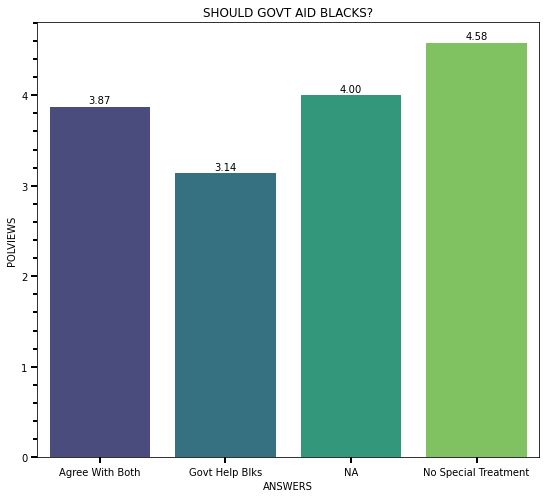

In [18]:
fig = plt.figure(figsize=(9,8))

g = sns.barplot(data=helpblk, 
                x="HELPBLK", y="POLVIEWS", 
                palette="viridis")
show_values(g)

g.set_title("SHOULD GOVT AID BLACKS?")

g.set_xlabel("ANSWERS")

g.yaxis.set_minor_locator(AutoMinorLocator(5))

g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("helpblks.png", dpi=300)

In [19]:
helpsick = df.groupby("HELPSICK").agg({"POLVIEWS": "mean"})
helpsick.reset_index(inplace=True)

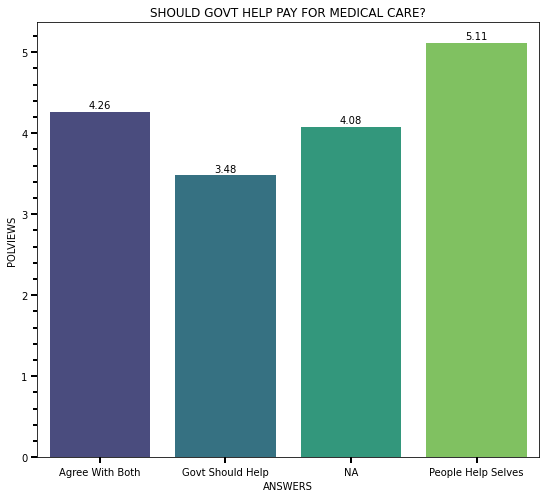

In [20]:
fig = plt.figure(figsize=(9,8))

g = sns.barplot(data=helpsick, 
                x="HELPSICK", y="POLVIEWS", 
                palette="viridis")
show_values(g)

g.set_title("SHOULD GOVT HELP PAY FOR MEDICAL CARE?")

g.set_xlabel("ANSWERS")

g.yaxis.set_minor_locator(AutoMinorLocator(5))

g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("helpsick.png", dpi=300)

In [21]:
abany = df.groupby("ABANY").agg({"POLVIEWS": "mean"})
abany.reset_index(inplace=True)

In [22]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

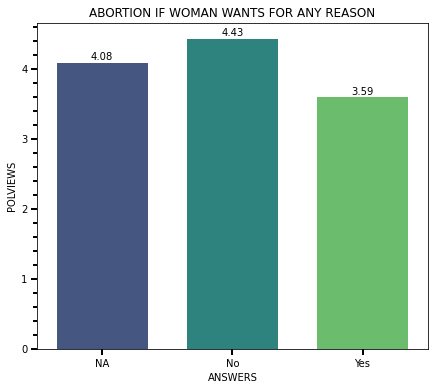

In [23]:
fig = plt.figure(figsize=(7,6))

g = sns.barplot(data=abany, 
                x="ABANY", y="POLVIEWS", 
                palette="viridis", dodge=False)
show_values(g)

g.set_title("ABORTION IF WOMAN WANTS FOR ANY REASON")

g.set_xlabel("ANSWERS")

g.yaxis.set_minor_locator(AutoMinorLocator(5))

g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

change_width(g, .7)
fig.savefig("abany.png", dpi=300)

In [24]:
confed = df.groupby("CONFED").agg({"POLVIEWS": "mean"})
confed.reset_index(inplace=True)

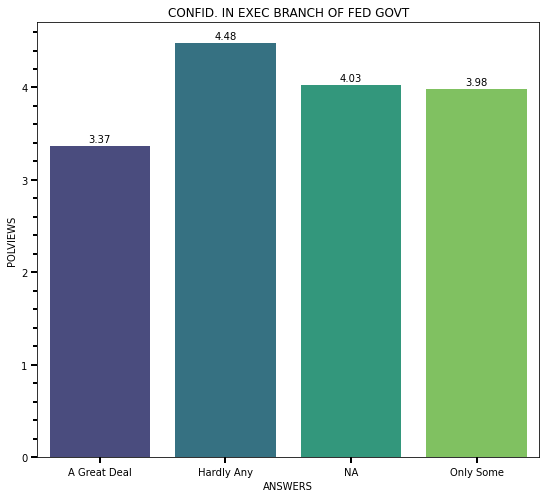

In [25]:
fig = plt.figure(figsize=(9,8))

g = sns.barplot(data=confed, 
                x="CONFED", y="POLVIEWS", 
                palette="viridis")
show_values(g)

g.set_title("CONFID. IN EXEC BRANCH OF FED GOVT")

g.set_xlabel("ANSWERS")

g.yaxis.set_minor_locator(AutoMinorLocator(5))

g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("confed.png", dpi=300)

In [26]:
natenvir = df.groupby("NATENVIR").agg({"POLVIEWS": "mean"})
natenvir.reset_index(inplace=True)

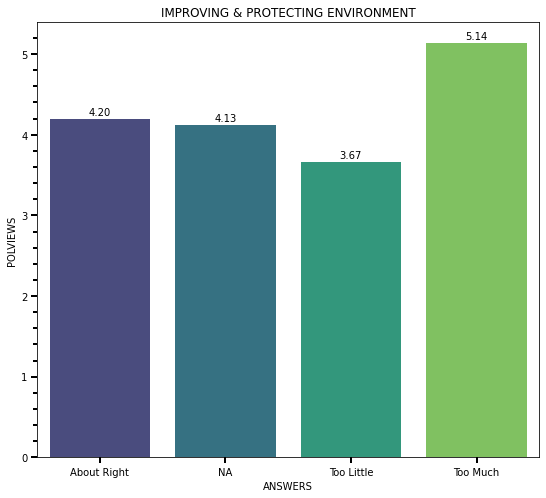

In [27]:
fig = plt.figure(figsize=(9,8))

g = sns.barplot(data=natenvir, 
                x="NATENVIR", y="POLVIEWS", 
                palette="viridis")
show_values(g)

g.set_title("IMPROVING & PROTECTING ENVIRONMENT")

g.set_xlabel("ANSWERS")

g.yaxis.set_minor_locator(AutoMinorLocator(5))

g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("natenvir.png", dpi=300)

In [28]:
helppoor = df.groupby("HELPPOOR").agg({"POLVIEWS": "mean"})
helppoor.reset_index(inplace=True)

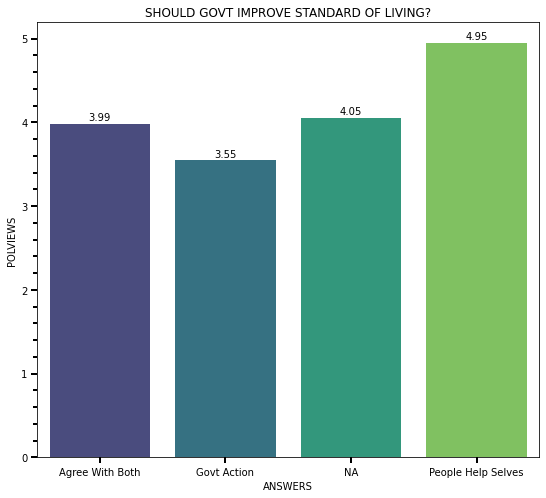

In [29]:
fig = plt.figure(figsize=(9,8))

g = sns.barplot(data=helppoor, 
                x="HELPPOOR", y="POLVIEWS", 
                palette="viridis")
show_values(g)

g.set_title("SHOULD GOVT IMPROVE STANDARD OF LIVING?")

g.set_xlabel("ANSWERS")

g.yaxis.set_minor_locator(AutoMinorLocator(5))

g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("helppoor.png", dpi=300)

In [30]:
age = df.groupby("POLVIEWS").agg({"AGE": "mean"})
age.reset_index(inplace=True)

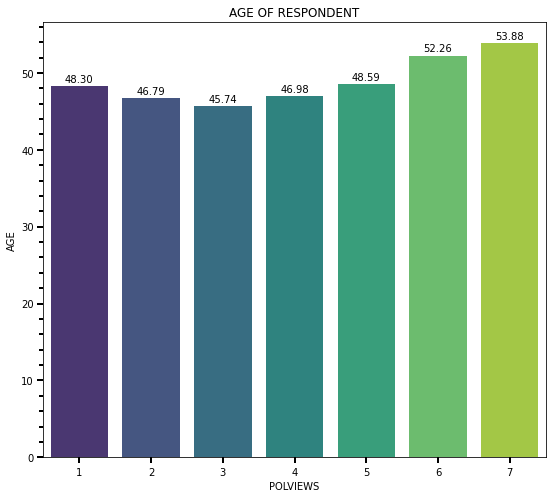

In [31]:
fig = plt.figure(figsize=(9,8))

g = sns.barplot(data=age, 
                x="POLVIEWS", y="AGE", 
                palette="viridis")
show_values(g)

g.set_title("AGE OF RESPONDENT")

g.set_xlabel("POLVIEWS")

g.yaxis.set_minor_locator(AutoMinorLocator(5))

g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("age.png", dpi=300)

In [32]:
for col in df.columns:
    if "HELP" in col:
        df.loc[df[col] == "DK", col] = "Agree With Both"
    elif "CON" in col:
        df.loc[df[col] == "DK", col] = "Only Some"
    elif "ENVIR" in col:
        df.loc[df[col] == "DK", col] = "About Right"
    else:
        continue

In [33]:
abany = df.groupby("ABANY").agg({"POLVIEWS": "mean"})
abany.reset_index(inplace=True)

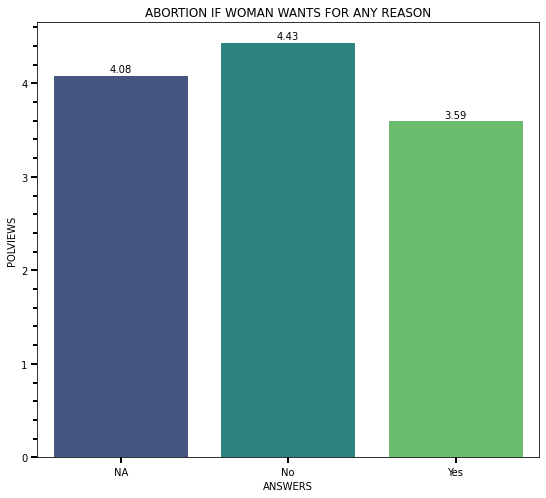

In [34]:
fig = plt.figure(figsize=(9,8))

g = sns.barplot(data=abany, 
                x="ABANY", y="POLVIEWS", 
                palette="viridis")
show_values(g)

g.set_title("ABORTION IF WOMAN WANTS FOR ANY REASON")

g.set_xlabel("ANSWERS")

g.yaxis.set_minor_locator(AutoMinorLocator(5))

g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("abany_1.png", dpi=300)

In [35]:
helpblk = df.groupby("HELPBLK").agg({"POLVIEWS": "mean"})
helpblk.reset_index(inplace=True)

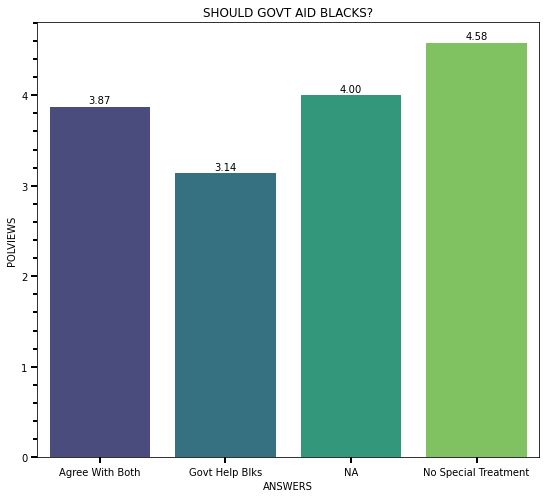

In [36]:
fig = plt.figure(figsize=(9,8))

g = sns.barplot(data=helpblk, 
                x="HELPBLK", y="POLVIEWS", 
                palette="viridis")
show_values(g)

g.set_title("SHOULD GOVT AID BLACKS?")

g.set_xlabel("ANSWERS")

g.yaxis.set_minor_locator(AutoMinorLocator(5))

g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("helpblks1.png", dpi=300)

In [37]:
helpsick = df.groupby("HELPSICK").agg({"POLVIEWS": "mean"})
helpsick.reset_index(inplace=True)

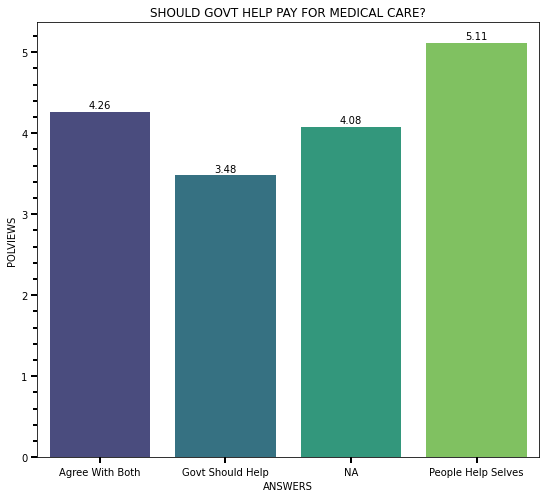

In [38]:
fig = plt.figure(figsize=(9,8))

g = sns.barplot(data=helpsick, 
                x="HELPSICK", y="POLVIEWS", 
                palette="viridis")
show_values(g)

g.set_title("SHOULD GOVT HELP PAY FOR MEDICAL CARE?")

g.set_xlabel("ANSWERS")

g.yaxis.set_minor_locator(AutoMinorLocator(5))

g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("helpsick1.png", dpi=300)

In [39]:
natenvir = df.groupby("NATENVIR").agg({"POLVIEWS": "mean"})
natenvir.reset_index(inplace=True)

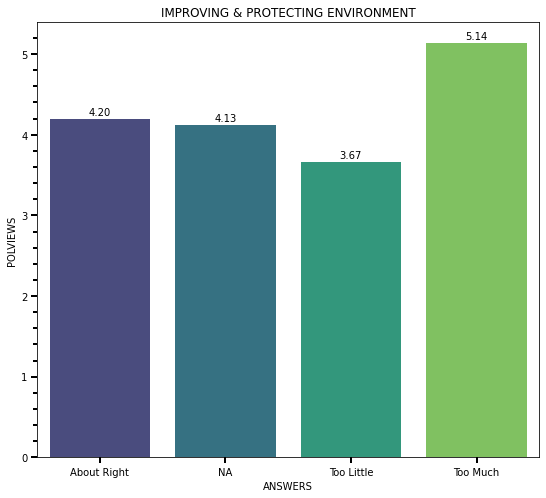

In [40]:
fig = plt.figure(figsize=(9,8))

g = sns.barplot(data=natenvir, 
                x="NATENVIR", y="POLVIEWS", 
                palette="viridis")
show_values(g)

g.set_title("IMPROVING & PROTECTING ENVIRONMENT")

g.set_xlabel("ANSWERS")

g.yaxis.set_minor_locator(AutoMinorLocator(5))

g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("natenvir1.png", dpi=300)

In [41]:
helppoor = df.groupby("HELPPOOR").agg({"POLVIEWS": "mean"})
helppoor.reset_index(inplace=True)

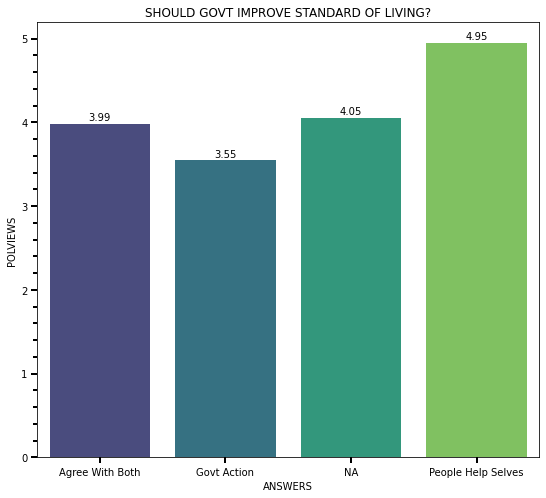

In [42]:
fig = plt.figure(figsize=(9,8))

g = sns.barplot(data=helppoor, 
                x="HELPPOOR", y="POLVIEWS", 
                palette="viridis")
show_values(g)

g.set_title("SHOULD GOVT IMPROVE STANDARD OF LIVING?")

g.set_xlabel("ANSWERS")

g.yaxis.set_minor_locator(AutoMinorLocator(5))

g.tick_params(which="both", width=2)
g.tick_params(which="major", length=6)
g.tick_params(which="minor", length=4)

fig.savefig("helppoor1.png", dpi=300)